In [2]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


In [3]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import pickle
# thư viện dùng để đọc file excel .csv
import pandas as pd

In [5]:
# lấy data traffic sign từ tập dữ liệu german-traffic-signs
# unpickle object từ file test.p
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  valid_data = pickle.load(f)
print(type(test_data))
# dataset ở trên là một cặp dict chứa feature biển báo và label tương ứng với biển báo đó
X_test, y_test = test_data['features'], test_data['labels']
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = valid_data['features'], valid_data['labels']

<class 'dict'>


In [6]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [7]:
assert(X_train.shape[0] == y_train.shape[0]), 'The number of images is not equal to the number of labels'
assert(X_test.shape[0] == y_test.shape[0]), 'The number of images is not equal to the number of labels'
assert(X_val.shape[0] == y_val.shape[0]), 'The number of images is not equal to the number of labels'
assert(X_train.shape[1:] == (32,32,3)), 'The dimensions of images is not equal 32x32x3'
assert(X_test.shape[1:] == (32,32,3)), 'The dimensions of images is not equal 32x32x3'
assert(X_val.shape[1:] == (32,32,3)), 'The dimensions of images is not equal 32x32x3'

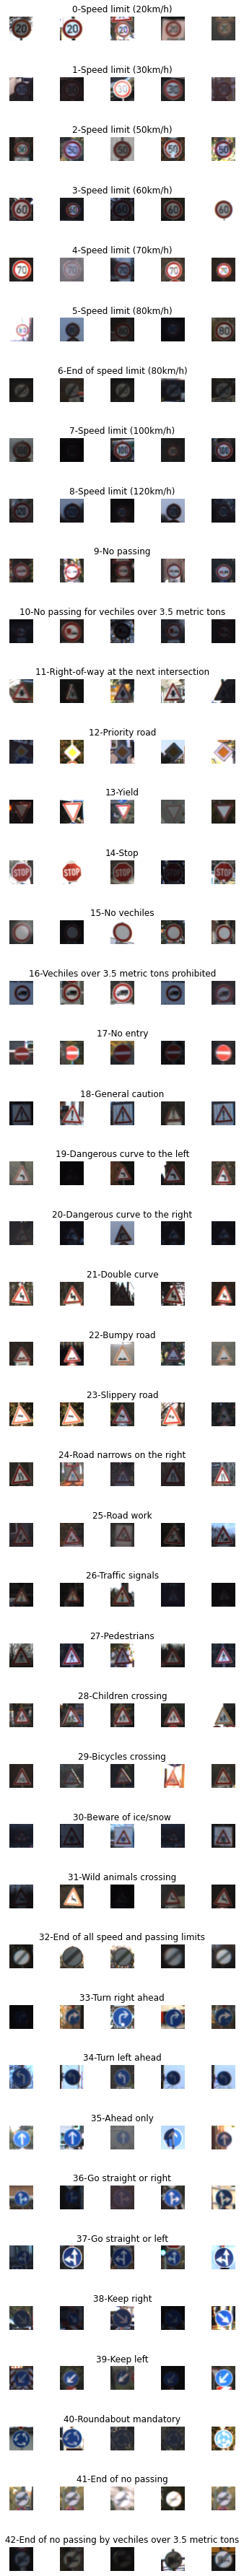

In [8]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []
cols = 5
num_classes = data.shape[0]
fig, ax = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
plt.tight_layout()
for i in range(cols):
  # data.iterrows() gồm (index, series)
  # index là cột thứ tự
  # series là cột SignName
  for j, row in data.iterrows():
    x_selected = X_train[y_train==j]
    ax[j][i].imshow(x_selected[random.randint(0, len(x_selected-1)),:,:,:], cmap=plt.get_cmap('gray'))
    ax[j][i].axis('off')
    if i==2:
      ax[j][i].set_title(str(j) + '-' + row['SignName'])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


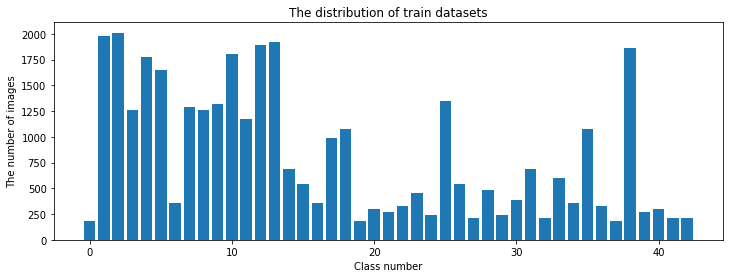

In [9]:
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.xlabel('Class number')
plt.ylabel('The number of images')
plt.title('The distribution of train datasets')
print(num_of_samples)

(32, 32, 3)
36


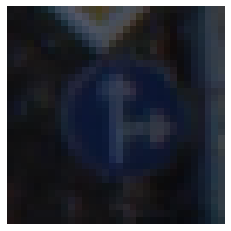

In [10]:
# Import một image để xử lí
import cv2
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


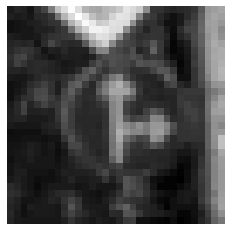

In [11]:
# convert gray image để histogram equalization
def gray_scale(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return img
img = gray_scale(X_train[1000])
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')
print(img.shape)

(-0.5, 31.5, 31.5, -0.5)

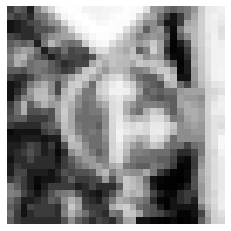

In [12]:
# histogram equalization giúp cân bằng độ sáng image và tăng độ tương phản
def equalize(img):
  img = cv2.equalizeHist(img)
  return img
img = equalize(img)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')

In [13]:
# Áp dụng bước pre-processing cho toàn bộ dataset
def preprocessing(img):
  img = gray_scale(img)
  img = equalize(img)
  img = img/255
  return img
# hàm map có chức năng thực hiện hàm preprocessing cho tất cả image trong X_train
# trả về kiểu list để đến bước tiếp theo là imshow image
# np.array biến thành array để imshow
X_train = np.array(list(map(preprocessing, X_train)))
X_test = np.array(list(map(preprocessing, X_test)))
X_val = np.array(list(map(preprocessing, X_val)))

(34799, 32, 32)


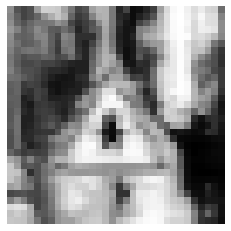

In [14]:
# imshow image để xem kết quả xử lí
plt.imshow(X_train[random.randint(0, len(X_train-1))], cmap=plt.get_cmap('gray'))
plt.axis('off')
print(X_train.shape)

In [15]:
# reshape image dimensions và label one hot coding để đưa vào training model
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [16]:
# data augmentation technique
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)

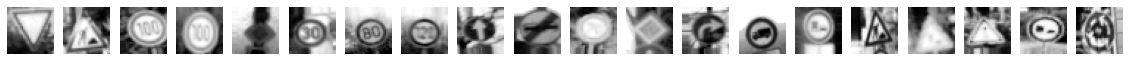

In [17]:
# model xử lí các bước trên với tập X_train
datagen.fit(X_train)   
# tạo data mới từ tập X_train, mỗi lặp lại sẽ chọn 20 image bất kì để thực hiện
batches = datagen.flow(X_train, y_train, batch_size=50)
# X_batch sẽ lưu trữ các image mới tạo ra từ batches
# next(batches) trả về các phần tử được tạo ra tiếp theo của iterator batches
X_batch, y_batch = next(batches)
fig, ax = plt.subplots(1, 20, figsize=(20,5))
for i in range(20):
  ax[i].imshow(X_batch[i].reshape(32,32), cmap=plt.get_cmap('gray'))
  ax[i].axis('off')

In [18]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(filters=60, kernel_size=(5,5), input_shape=(32,32,1), activation='relu', strides=1, padding='valid'))
  model.add(Conv2D(filters=60, kernel_size=(5,5), input_shape=(32,32,1), activation='relu', strides=1, padding='valid'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(filters=30, kernel_size=(3,3), activation='relu'))
  model.add(Conv2D(filters=30, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  #model.add(Dropout(rate=0.5))
  model.add(Flatten())
  model.add(Dense(units=500, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(units=num_classes, activation='softmax'))
  model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics='Accuracy')
  return model

In [19]:
model = leNet_model()
#print(model.summary())
h = model.fit(datagen.flow(X_train, y_train, batch_size=50), 
              steps_per_epoch=695, 
              epochs=10, 
              verbose=1,
              validation_data=(X_val,y_val), 
              shuffle=1)

Epoch 1/10
695/695 [==============================] - 53s 33ms/step - loss: 1.7540 - Accuracy: 0.5046 - val_loss: 0.3625 - val_Accuracy: 0.8789
Epoch 2/10
695/695 [==============================] - 22s 32ms/step - loss: 0.5390 - Accuracy: 0.8369 - val_loss: 0.1315 - val_Accuracy: 0.9562
Epoch 3/10
695/695 [==============================] - 22s 31ms/step - loss: 0.3268 - Accuracy: 0.8979 - val_loss: 0.0705 - val_Accuracy: 0.9825
Epoch 4/10
695/695 [==============================] - 22s 32ms/step - loss: 0.2399 - Accuracy: 0.9260 - val_loss: 0.0913 - val_Accuracy: 0.9723
Epoch 5/10
695/695 [==============================] - 22s 32ms/step - loss: 0.1954 - Accuracy: 0.9416 - val_loss: 0.0562 - val_Accuracy: 0.9855
Epoch 6/10
695/695 [==============================] - 22s 32ms/step - loss: 0.1684 - Accuracy: 0.9492 - val_loss: 0.0493 - val_Accuracy: 0.9853
Epoch 7/10
695/695 [==============================] - 22s 31ms/step - loss: 0.1488 - Accuracy: 0.9551 - val_loss: 0.0459 - val_Accuracy:

Text(0.5, 1.0, 'Accuracy')

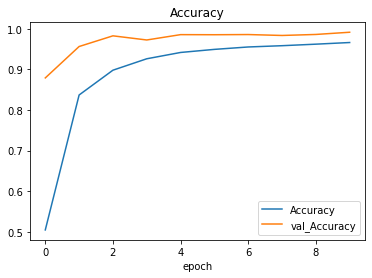

In [20]:
plt.plot(h.history['Accuracy'])
plt.plot(h.history['val_Accuracy'])
plt.legend(['Accuracy','val_Accuracy'])
plt.xlabel('epoch')
plt.title('Accuracy')

Text(0.5, 1.0, 'loss')

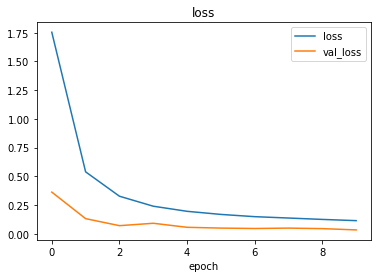

In [21]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('epoch')
plt.title('loss')

In [22]:
score = model.evaluate(X_test, y_test, verbose=0)
print('loss:', score[0])
print('accuracy',score[1])

loss: 0.12164159119129181
accuracy 0.9699128866195679


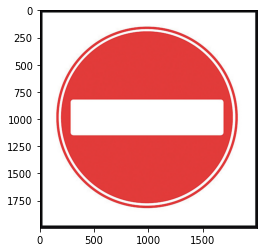

In [24]:
# Nhận dạng 1 biển báo lấy từ web
import requests   
from PIL import Image
url = 'https://cdn.images.fecom-media.com/FE00007318/images/HE1318852_1318852-P.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

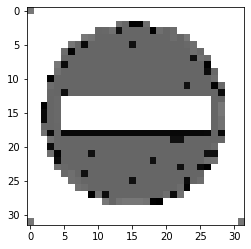

In [25]:
import cv2
img_array = np.asarray(img)
img_resized = cv2.resize(img_array, (32,32))
img = preprocessing(img_resized)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [26]:
img = img.reshape(1,32,32,1)
prediction = model.predict(img)
prediction = np.argmax(prediction, axis=1)
print('Prediction:',prediction)

Prediction: [17]
